## Seasonal decomposition - a study of a universal algorithm
Time windows decomposition aims to extract three main componets of the real-time data:
- trend
- seasonal
- residual

**Trend**  
Trend component can be thought as the innate underlying pattern - somewhat similar to the behaviour of stock prices. As they usually go up or down in the same manner.<br \>
**Seasonal**  
Is the actual measure of periodic trends. It can be thought as the periodicity of data, as it marks the recurring trends.<br \>
**Residual**  
Residual data is simply a leftover, noise or anomaly data that could not be fit into the upper two categories.

### Identifying the general compiste model
We can roughly guess that our models can behave in two distinct ways.  
Each of these "ways" can be modelled by a different mathematical description - either we end up with *additive* or *multiplicative* model. 

Anticipating the resulting model we can write:  
**Additive model** 
$$y(t) = offset + Trend + Seasonal + Noise = Trend + Seasonal + Residual$$
**Multiplicative model**
$$y(t) = offset \times Trend \times Seasonal \times Noise = Trend \times Seasonal \times Residual$$

However, at this point above models are of little of use for extracting seperate componets from the real dataset.
Therefore, we need an algorithm to decompose each of these models sepearately into constituents.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

writer =pd.ExcelWriter('AMZN.xlsx')
df = pd.read_csv("AMZN_data.csv")
df.to_excel(writer, 'Sheet1')

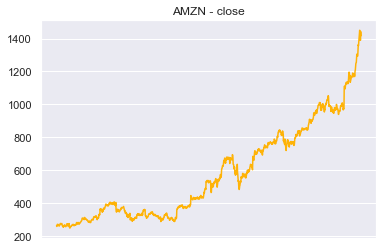

In [2]:
col = 'close'
plt.plot(df[col], color=sns.xkcd_rgb['amber'])
plt.title("AMZN - {}".format(col))
plt.xticks([])
plt.savefig("Amzn")

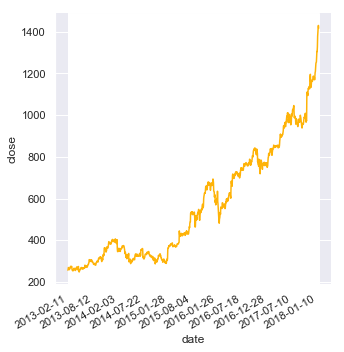

In [3]:
gplot = sns.relplot(x='date', y='close', legend ='brief', kind='line', data=df.sample(1000), color=sns.xkcd_rgb['amber'])
gplot.fig.autofmt_xdate()
for ind, label in enumerate(gplot.ax.get_xticklabels()):
    vis = False
    if ind%99== 0:
        vis = True
    label.set_visible(vis)

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose 
# seasonal decomposition - we use a yearly frequency because it is long enough for the granuality of our data
# firstly the most basic model - an additive one, as it seems that this might be the natural way to interpret stocks 
# as some trend with noise
result = seasonal_decompose(df[col], model='additive', freq=365)

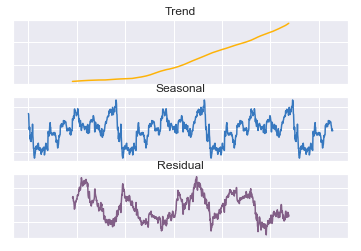

In [5]:
fig = plt.figure()
ax1 = plt.subplot(311)
ax2 = plt.subplot(312)
ax3 = plt.subplot(313)

ax1.set_title("Trend")
ax2.set_title("Seasonal")
ax3.set_title("Residual")
ax2.get_shared_x_axes().join(ax2, ax3)
ax1.get_shared_x_axes().join(ax1, ax2)
for ax in [ax1, ax2, ax3]:
    ax.set_xticklabels([])
    ax.set_yticklabels([])

sns.lineplot(data=result.trend, ax=ax1, color=sns.xkcd_rgb['amber'])
sns.lineplot(data=result.seasonal, ax=ax2, color=sns.xkcd_rgb['windows blue'])
sns.lineplot(data=result.resid, ax=ax3, color=sns.xkcd_rgb['dusty purple'])
plt.savefig("Dec.png")
plt.show()
# as expected we should see that the trend is visibly raising. However, the periodicity is much more interesting as we 
# can see visible yearly trends. Most likely spikes represents the AMAZON budget or net income reveal

In [6]:
# creating pandas dataframe to make further processing and plotting easier
decomposed_df = pd.DataFrame({'trend': result.trend, 
                              'seasonal': result.seasonal, 
                              'residual': result.resid})
decomposed_df.to_excel(writer, "Sheet 2")

In [7]:
for col, col_hue in zip(['trend', 'seasonal', 'residual'], ['amber', 'windows blue', 'dusty purple']):
    plt.plot(decomposed_df[col], color=sns.xkcd_rgb[col_hue])
    plt.title("{}".format(col))
    plt.savefig("Dec"+col+".png")
    plt.clf()

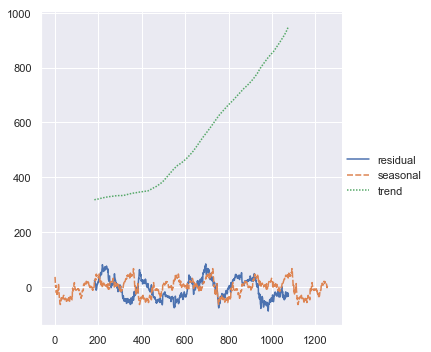

In [8]:
gplot = sns.relplot(hue=['trend', 'seasonal', 'residual'], 
                    legend ='brief', kind='line', data=decomposed_df)
# this displays also the comparative scale of the seasonality, residual and trend. Trend dominates over the rest visibly

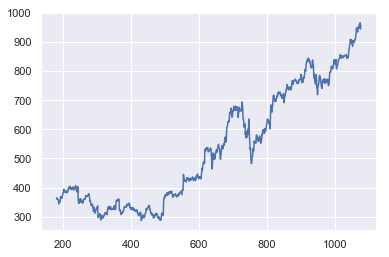

In [9]:
# testing if putting the model back matches the original - an additive model
plt.plot(decomposed_df['trend']+decomposed_df['seasonal']
         +decomposed_df['residual'])

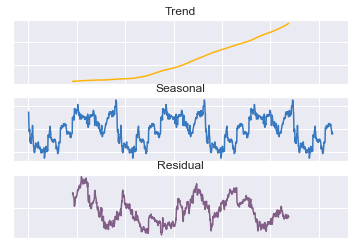

In [10]:
# we repeat the run for the different model, keeping the same frequency
col = 'close'
result2 = seasonal_decompose(df[col], model='multiplicative', freq=365)
fig = plt.figure()
ax1 = plt.subplot(311)
ax2 = plt.subplot(312)
ax3 = plt.subplot(313)

ax1.set_title("Trend")
ax2.set_title("Seasonal")
ax3.set_title("Residual")
ax2.get_shared_x_axes().join(ax2, ax3)
ax1.get_shared_x_axes().join(ax1, ax2)
for ax in [ax1, ax2, ax3]:
    ax.set_xticklabels([])
    ax.set_yticklabels([])

sns.lineplot(data=result2.trend, ax=ax1, color=sns.xkcd_rgb['amber'])
sns.lineplot(data=result2.seasonal, ax=ax2, color=sns.xkcd_rgb['windows blue'])
sns.lineplot(data=result2.resid, ax=ax3, color=sns.xkcd_rgb['dusty purple'])
decomposed_df2 = pd.DataFrame({'trend': result2.trend, 
                               'seasonal': result2.seasonal, 
                               'residual': result2.resid})


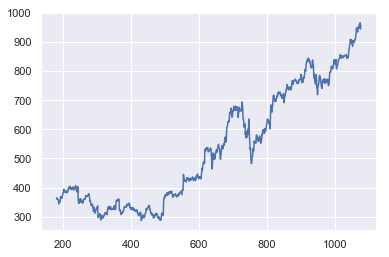

In [11]:
# testing if putting the model back matches the original - a multiplicative model
plt.plot(decomposed_df2['trend']*decomposed_df2['seasonal']
         *decomposed_df2['residual'])

Text(0.5,1,'Critical value in function of degrees of freedom')

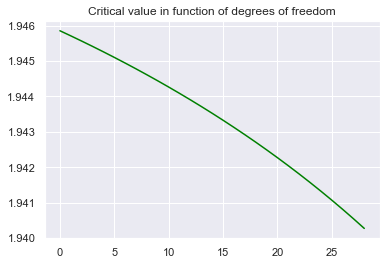

In [12]:
import numpy as np
from scipy import stats

def calcualte_crit(nmk, tp=0.025):
    tval = stats.t.ppf(1-tp,nmk-1)
    return (nmk)*tval/np.sqrt((nmk-1+tval**2)*(nmk+1))
n = 100
k = 30 # expected, upper bound on anomalies. Note that k < (n/2 -1)
datapoints = []
x_points = []
for i in range(1, k):
    x_points.append(i-1)
    datapoints.append(calcualte_crit(n-i))
    
plt.plot(x_points, datapoints, color='green')
plt.title("Critical value in function of degrees of freedom")

Used dataset for Amazon stock prices https://www.kaggle.com/camnugent/sandp500/version/4#